### Anomaly Detection on ECG data

In [152]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from numpy.random import seed
sns.set(color_codes=True)

%matplotlib inline

# code for Tensorflow 2 !!!
print(tf.__version__)
assert(tf.__version__ >= '2.')

2.1.0


In [23]:
FILE_NAME = "ECG5000_TEST.txt"

data = pd.read_csv(FILE_NAME, delim_whitespace = True, header=None, engine = 'python')

In [24]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,1.0,3.690844,0.711414,-2.114092,-4.141007,-4.574472,-3.431909,-1.950791,-1.107067,-0.632322,...,-0.032477,0.022847,0.188937,0.480932,0.629250,0.577291,0.665527,1.035997,1.492287,-1.905073
1,1.0,-1.348132,-3.996038,-4.226750,-4.251187,-3.477953,-2.228422,-1.808488,-1.534242,-0.779861,...,0.937984,1.570938,1.591394,1.549193,1.193077,0.515134,0.126274,0.267532,1.071148,-1.164009
2,1.0,1.024295,-0.590314,-1.916949,-2.806989,-3.527905,-3.638675,-2.779767,-2.019031,-1.980754,...,0.368820,0.443502,0.827582,1.237007,1.235121,1.738103,1.800767,1.816301,1.473963,1.389767
3,1.0,0.545657,-1.014383,-2.316698,-3.634040,-4.196857,-3.758093,-3.194444,-2.221764,-1.588554,...,0.894638,0.777530,1.119240,0.902984,0.554098,0.497053,0.418116,0.703108,1.064602,-0.044853
4,1.0,0.661133,-1.552471,-3.124641,-4.313351,-4.017042,-3.005993,-1.832411,-1.503886,-1.071705,...,1.416582,1.280823,1.494316,1.618764,1.447449,1.238577,1.749692,1.986803,1.422756,-0.357784


In [25]:
data_vec = data.to_numpy()

In [58]:
def plot_ecg(vec, index):
    label = vec[index, 0]
    
    vet = vec[index, 1:]
    time = np.arange(len(vet))

    plt.figure(figsize = (12,6))

    plt.plot(time, vet, 'b')

    plt.xlabel('Time')
    plt.ylabel('Signal')
    
    print("Label is: %d" %(label))
    plt.show()

In [68]:
# scale in (0,1) but mantains curve shape
def scale_ecg(vec):
    new_vec = (vec - vec.min())/(vec.max() - vec.min())
    return new_vec

Label is: 1


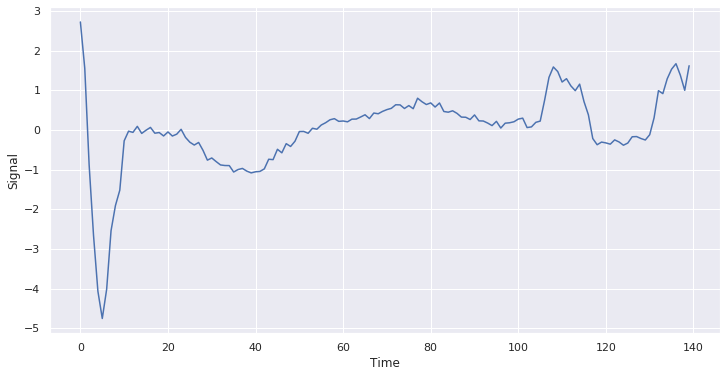

In [150]:
# visualizziamo un generico frammento ECG
plot_ecg(data_vec, 1000)

In [70]:
#  vediamo quante sono le varie categorie
numbers = data.groupby(0).count()

numbers[1]

0
1.0    2627
2.0    1590
3.0      86
4.0     175
5.0      22
Name: 1, dtype: int64

In [71]:
# per il training prendo solo i tracciati NORMAL (label = 1)
condition = (data[0] == 1.)
data_normal = data[condition]

X = np.array(data_normal)

# elimino la prima colonna (target)
X = X[:, 1:]

In [72]:
# devo scalare i valori
# X_scaled = X/5.
X_scaled = scale_ecg(X)

In [73]:
X_scaled.shape

(2627, 140)

Label is: 0


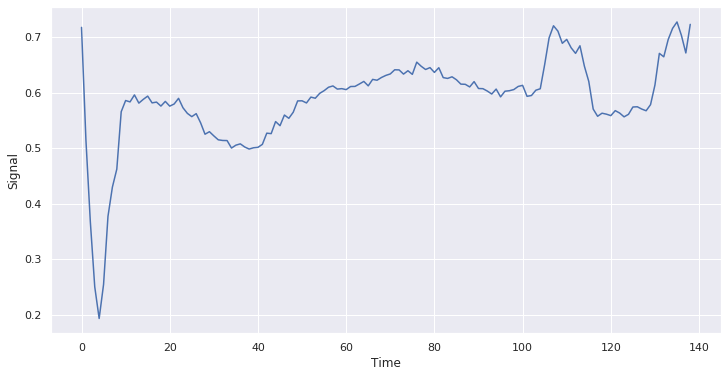

In [151]:
plot_ecg(X_scaled, 1000)

In [75]:
# define the NN

seed(1234)
tf.random.set_seed(1234)

# numero di punti in ogni frammento
input_num = 140

# ho aumentato
my_reg = keras.regularizers.l1(10e-6)
# con elu va peggio
my_act = "relu"

# Input layer:
model = Sequential()

# First hidden layer, connected to input vector X. 
model.add(Dense(64, activation = my_act, input_shape=(input_num,), 
                # suggested from Chollet Blog on Autoencoders
                activity_regularizer = my_reg 
               )
         )
model.add(Dense(32,activation = my_act, activity_regularizer = my_reg))
model.add(Dense(16,activation = my_act, activity_regularizer = my_reg))
model.add(Dense(32, activation = my_act))
model.add(Dense(64, activation = my_act))
model.add(Dense(input_num))

model.compile(loss='mse', optimizer='adam')

In [76]:
# as we can see the network has input = 140, output = 140 !!!
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                9024      
_________________________________________________________________
dense_13 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_14 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_15 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_16 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_17 (Dense)             (None, 140)               9100      
Total params: 23,388
Trainable params: 23,388
Non-trainable params: 0
__________________________________________________

In [77]:
# Train the model
# NUM_EPOCHS = 1500
NUM_EPOCHS = 2000
BATCH_SIZE = 128
VAL_SPLIT = 0.1
NO_VERBOSE = 0

history = model.fit(X_scaled, X_scaled, batch_size = BATCH_SIZE, epochs = NUM_EPOCHS, 
                           validation_split = VAL_SPLIT, verbose = 0)

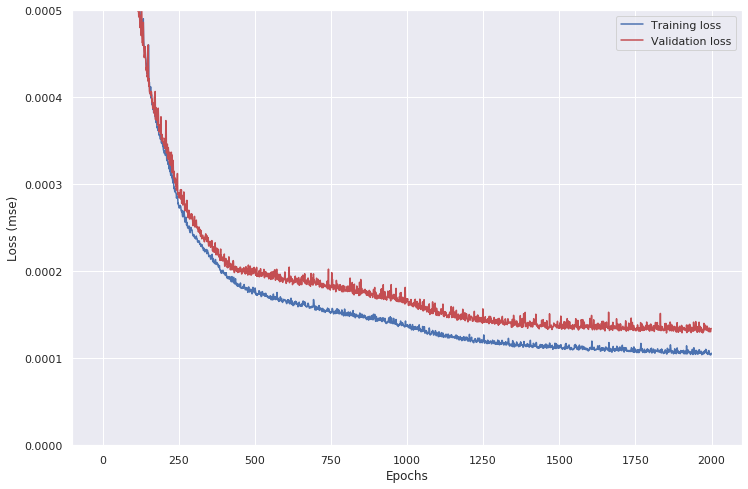

In [81]:
# visualize loss for the training (avoid first epochs to see improvements)
plt.figure(figsize = (12,8))
hist_loss = history.history['loss']
hist_val_loss = history.history['val_loss']

plt.plot(hist_loss,'b', label='Training loss')
plt.plot(hist_val_loss,'r', label='Validation loss')

plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss (mse)')
plt.ylim([0, 0.0005])

plt.show()

(0.0, 0.03)

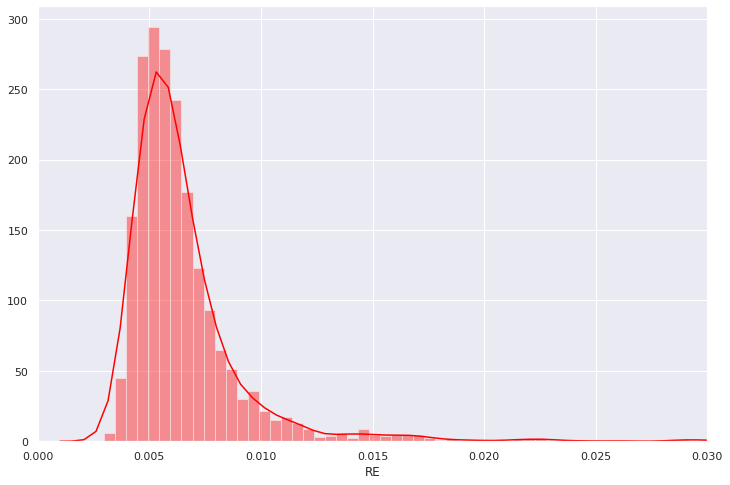

In [85]:
# prediction on train 
# RE: reconstruction error, calculated as MAE
X_pred = model.predict(X_scaled)

scored = pd.DataFrame()

# for every point compute the reconstruction error as MAE
scored['RE'] = np.mean(np.abs(X_pred - X_scaled), axis = 1)

# histogram
plt.figure(figsize = (12,8))
sns.distplot(scored['RE'], bins = 100, kde= True, color = 'red');

plt.xlim([0.0,0.03])

In [144]:
THRESHOLD = 0.0226

In [145]:
FILE_NAME_TEST = "ECG5000_TRAIN.txt"

data_test = pd.read_csv(FILE_NAME_TEST, delim_whitespace = True, header=None, engine = 'python')

In [146]:
X_test_old = np.array(data_test)
X_test = np.array(data_test)

# elimino la prima colonna (label)
X_test = X_test[:, 1:]

In [147]:
# scaling
# X_test_scaled = X_test/5.
X_test_scaled = scale_ecg(X_test)
# X_test_scaled = scaler.transform(X_test)

(0.0, 0.1)

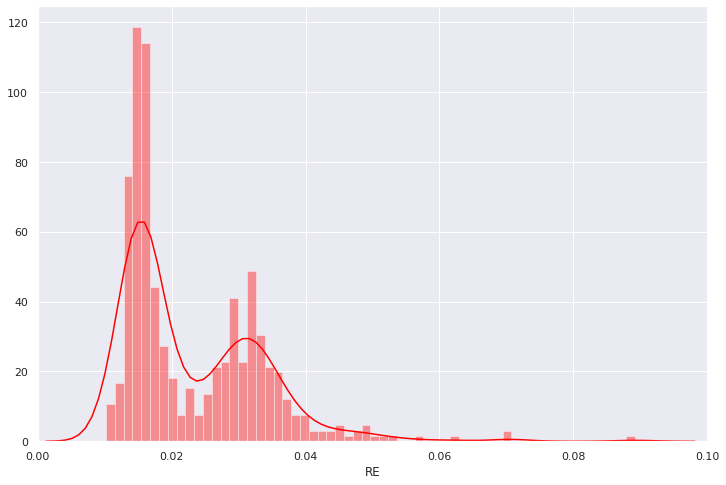

In [148]:
# compute prediction on TEST
X_pred_test = model.predict(X_test_scaled)

# colleziono i dati in scored_test
scored_test = pd.DataFrame()

# for every point compute the reconstruction error as MAE
scored_test['RE'] = np.mean(np.abs(X_pred_test - X_test_scaled), axis = 1)
scored_test['label'] = X_test_old[:, 0]
scored_test['Anomaly_reg'] = (scored_test['label'] != 1.)
scored_test['Anomaly_pred'] = scored_test['RE'] > THRESHOLD

plt.figure(figsize = (12,8))

# histogram
sns.distplot(scored_test['RE'], bins = 60, kde = True, color = 'red');

plt.xlim([0.0,0.1])

In [149]:
# calcolo l'accuratezza
acc_condition = (scored_test['Anomaly_reg'] == scored_test['Anomaly_pred'])

accuracy = sum(acc_condition)/X_test.shape[0]

print("Accuracy on TEST is: %.3f" %(accuracy))

Accuracy on TEST is: 0.970


In [131]:
numbers = scored_test.groupby('Anomaly_reg').count()

In [124]:
numbers['label']

Anomaly_reg
False    292
True     208
Name: label, dtype: int64